In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import geopandas as gpd
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
sys.path.insert(1,'../../scripts/03_plant_optimization/')

In [4]:
import plant_optimization as pop
from plant_optimization.notebook_tools import *

In [5]:
europe_grid = gpd.read_file('../../data/Countries_WGS84/processed/Europe_Evaluation_Grid.shp')
europe_grid.rename(columns={'grid_lat':'lat','grid_lon':'lon'},inplace=True)
europe_grid['sea_node'] = europe_grid.sea_node.astype(bool)
europe_borders = gpd.read_file('../../data/Countries_WGS84/processed/Europe_WGS84.shp')

In [6]:
EU_EFTA = europe_grid.country.unique()

In [7]:
results_path = os.path.join('../../results/02_plant_optimization') # Points to the location of the results csv files

In [8]:
def plot_results(data,countries,metrics,figsize=(25,20),ncols=None,fontsize=None,cmap=None,vmax_dict={},missing_kwds=None,legend_kwds={}):
    if ncols == None:
        ncols = int(np.ceil(np.sqrt(len(metrics))))
    nrows = int(np.ceil(len(metrics)/ncols))
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    axes = np.reshape(axes,(1,nrows*ncols))[0]

    if fontsize == None:
        fontsize = figsize[0]*2
    df = data.loc[data.country.isin(countries)].copy()
    borders = europe_borders.loc[europe_borders.country.isin(countries)].copy()
    cmap = 'viridis_r'
    for i,(metric,description) in enumerate(metrics.items()):
        vmax = vmax_dict[metric] if metric in vmax_dict.keys() else None
        if metric not in ['turbine_type','specific_capacity_class']:
            l_kwds = legend_kwds.copy()
            l_kwds.setdefault('orientation','horizontal')
            l_kwds['ax'] = axes[i]
            l_kwds.pop('bbox_to_anchor',None)
            l_kwds.pop('fontsize',None)
            if l_kwds['orientation'] == 'vertical':
                divider = make_axes_locatable(axes[i])
                cax = divider.append_axes("right", size="3%", pad=-2)
            else:
                cax = None
        else:
            l_kwds = legend_kwds.copy()
            l_kwds.pop('orientation',None)
            l_kwds.setdefault('loc','upper center')
            l_kwds.setdefault('ncol',min(3,df[metric].nunique()))
            l_kwds.setdefault('fontsize',fontsize*.75)
            cax = None
            if df[metric].nunique()>10:
                cmap = 'tab20'
        if not any(df[metric].isna()):
            m_kwds = None
        else:
            m_kwds = missing_kwds
        df.plot(column=metric,legend=True,cmap=cmap,vmax=vmax,missing_kwds=m_kwds,legend_kwds=l_kwds,cax=cax,ax=axes[i])
        borders.boundary.plot(color='k',ax=axes[i])
        cb_ax = axes[i].figure.axes[-1]
        cb_ax.tick_params(labelsize=fontsize)
        axes[i].tick_params(labelsize=fontsize)
        axes[i].axis('off')
        axes[i].set_title(description,fontsize=fontsize)
#     plt.tight_layout()

In [9]:
def plot_country(country,metrics,**plot_results_kwds):
    results = pd.DataFrame()
    for file_glob in glob(f'{results_path}/{country}*.csv'): 
        results = results.append(pd.read_csv(file_glob,index_col=0))
    results['country'] = country
    results_gdf = gpd.GeoDataFrame(results.merge(europe_grid,on=['lat','lon','country'],how='left'))
    results_gdf = results_gdf.loc[~results_gdf.sea_node]
    plot_results(data=results_gdf,metrics=metrics,countries=[country],**plot_results_kwds)

In [10]:
def drop_outliers(df,z_score_filter=5):
    data = df.copy()
    mask = abs(data.LCOF_liter.mean()-data.LCOF_liter)<z_score_filter*data.LCOF_liter.std()
    data = data.loc[mask]
    print(f'{len(df)-len(data)} outlier entries were dropped.')
    return data

# Maps

In [103]:
# countries = ['Switzerland','Austria','Germany','France','Italy']
countries = europe_grid.country.unique()
# countries = ['France']
results = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['sea_node'] = False
    df_sea = pd.DataFrame()
    # NOTE THAT THIS IS TAKING OFFSHORE RESULTS FROM RUN_01!!!
    for file_glob in glob(f'{results_path}/run_01/offshore/{country}*.csv'): 
        df_sea = df_sea.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df_sea['sea_node'] = True
    df = df.append(df_sea)
    df['country'] = country
    results = results.append(df)
results_gdf = gpd.GeoDataFrame(results.merge(europe_grid,on=['lat','lon','country','sea_node'],how='left'))

In [106]:
# This cell can be deleted once the offshore points are rerun
results_gdf.loc[(results_gdf.wind_class.isna())&(results_gdf.shore_dist<=60),'wind_class'] = 'monopole'
results_gdf.loc[(results_gdf.wind_class.isna())&(results_gdf.shore_dist>60),'wind_class'] = 'floating'

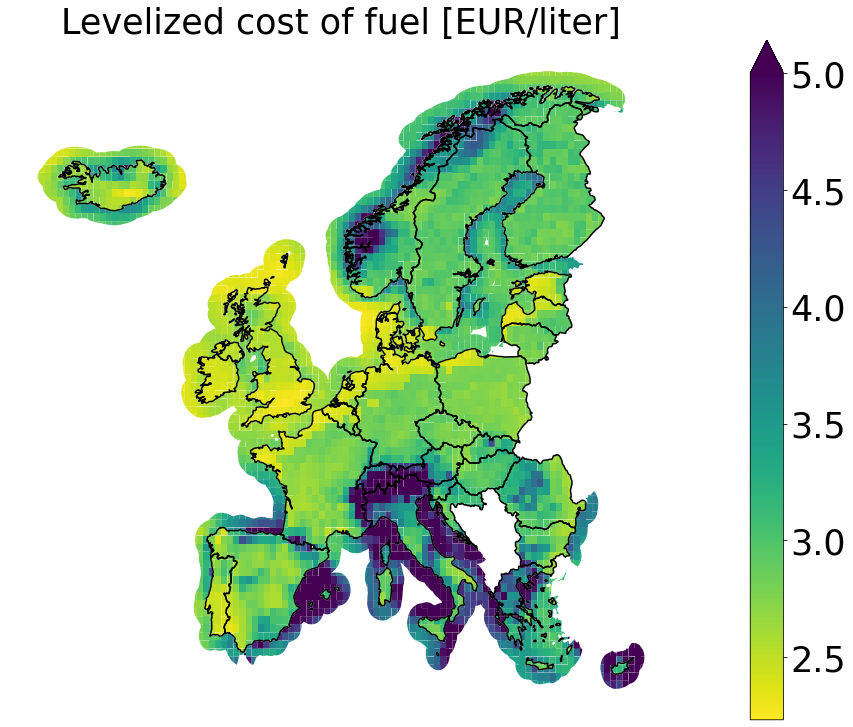

In [108]:
data = results_gdf.copy()
# countries = ['Switzerland','Austria','Germany']
metrics = {'LCOF_liter':'Levelized cost of fuel [EUR/liter]'}
vmax_dict = {'LCOF_liter':5}
legend_kwds = {'extend':'max','orientation':'vertical'}
fontsize = 35
plot_results(data=data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,legend_kwds=legend_kwds,figsize=(15,15),fontsize=fontsize)
plt.tight_layout()
# plt.savefig('../../gfx/LCOF_combined.png',dpi=400)

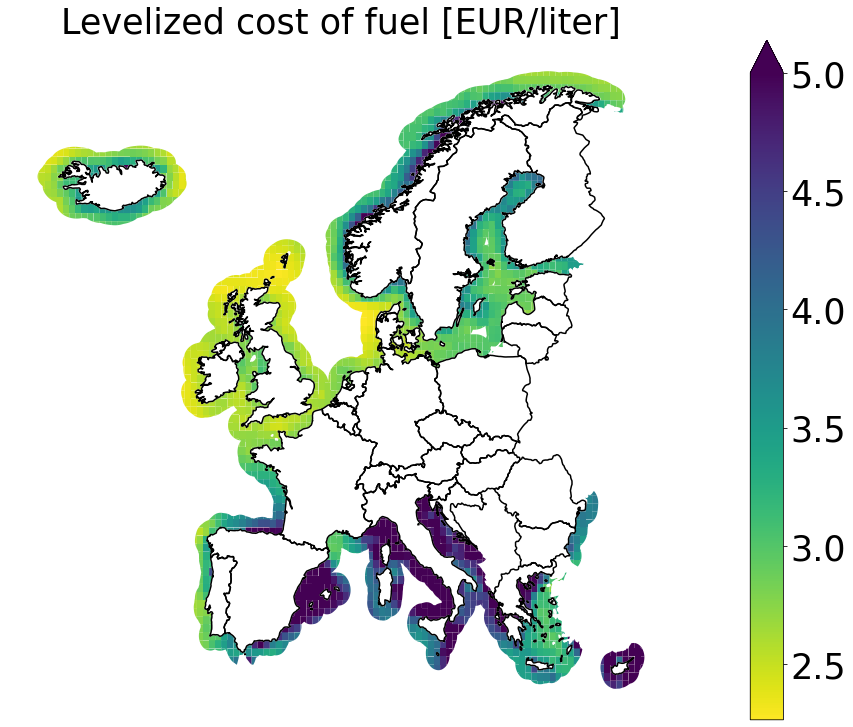

In [71]:
data = results_gdf.copy()
# countries = ['Switzerland','Austria','Germany']
metrics = {'LCOF_liter':'Levelized cost of fuel [EUR/liter]'}
vmax_dict = {'LCOF_liter':5}
legend_kwds = {'extend':'max','orientation':'vertical'}
fontsize = 35
plot_results(data=data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,legend_kwds=legend_kwds,figsize=(15,15),fontsize=fontsize)
plt.tight_layout()
# plt.savefig('../../gfx/LCOF_combined.png',dpi=400)

<AxesSubplot:>

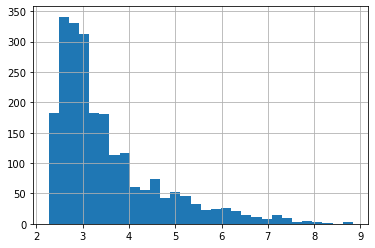

In [76]:
data.LCOF_liter.hist(bins=30)


## MAVT Article Figure

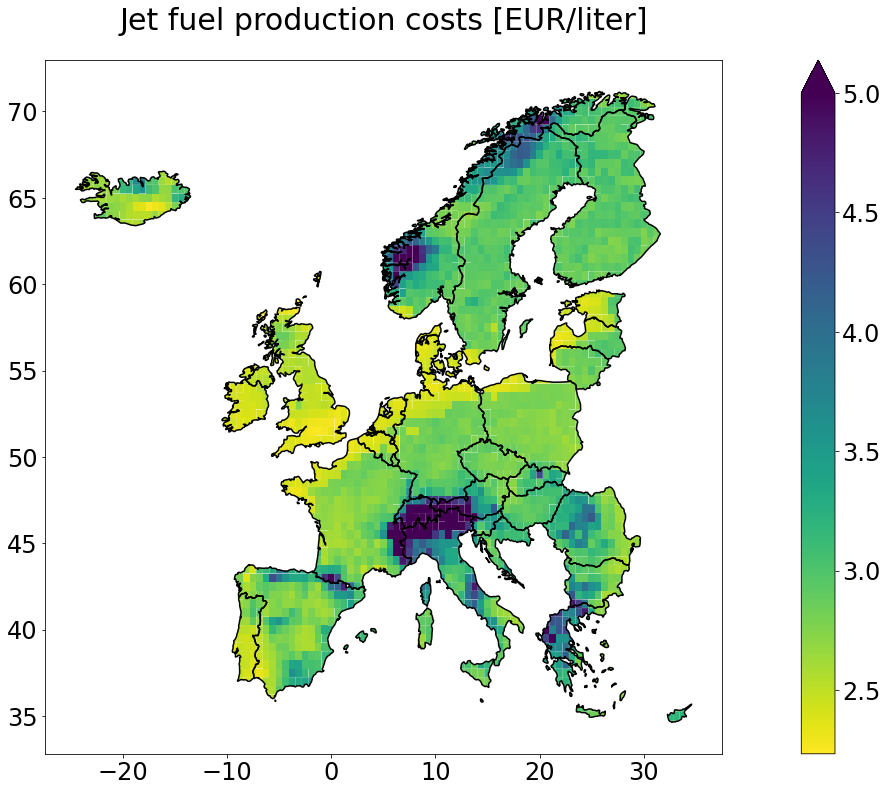

In [29]:
# MAVT Article
data = results_gdf.copy()
# countries = ['Switzerland','Austria','Germany']
metrics = {'LCOF_liter':'Jet fuel production costs [EUR/liter]'}
vmax_dict = {'LCOF_liter':5}
legend_kwds = {'extend':'max','orientation':'vertical'}
fontsize = 30
figsize = (15,15)

ncols = 1
nrows = 1
fig,axes = plt.subplots(nrows=1,ncols=1,figsize=figsize)
axes = np.reshape(axes,(1,nrows*ncols))[0]

df = data.loc[data.country.isin(countries)].copy()
borders = europe_borders.loc[europe_borders.country.isin(countries)].copy()
cmap = 'viridis_r'
for i,(metric,description) in enumerate(metrics.items()):
    vmax = vmax_dict[metric] if metric in vmax_dict.keys() else None
    if metric not in ['turbine_type','specific_capacity_class']:
        l_kwds = legend_kwds.copy()
        l_kwds.setdefault('orientation','horizontal')
        l_kwds['ax'] = axes[i]
        l_kwds.pop('bbox_to_anchor',None)
        l_kwds.pop('fontsize',None)
        if l_kwds['orientation'] == 'vertical':
            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes("right", size="3%", pad=-2)
        else:
            cax = None

    df.plot(column=metric,legend=True,cmap=cmap,vmax=vmax,legend_kwds=l_kwds,cax=cax,ax=axes[i])
    borders.boundary.plot(color='k',ax=axes[i])
    cb_ax = axes[i].figure.axes[-1]
    cb_ax.tick_params(labelsize=fontsize*.8)
    axes[i].tick_params(labelsize=fontsize*.8)
#         axes[i].axis('off')
    axes[i].set_title(description,fontsize=fontsize,pad=30)
    plt.tight_layout()
# plt.savefig('../../gfx/LCOF_onshore_box.eps',dpi=400)

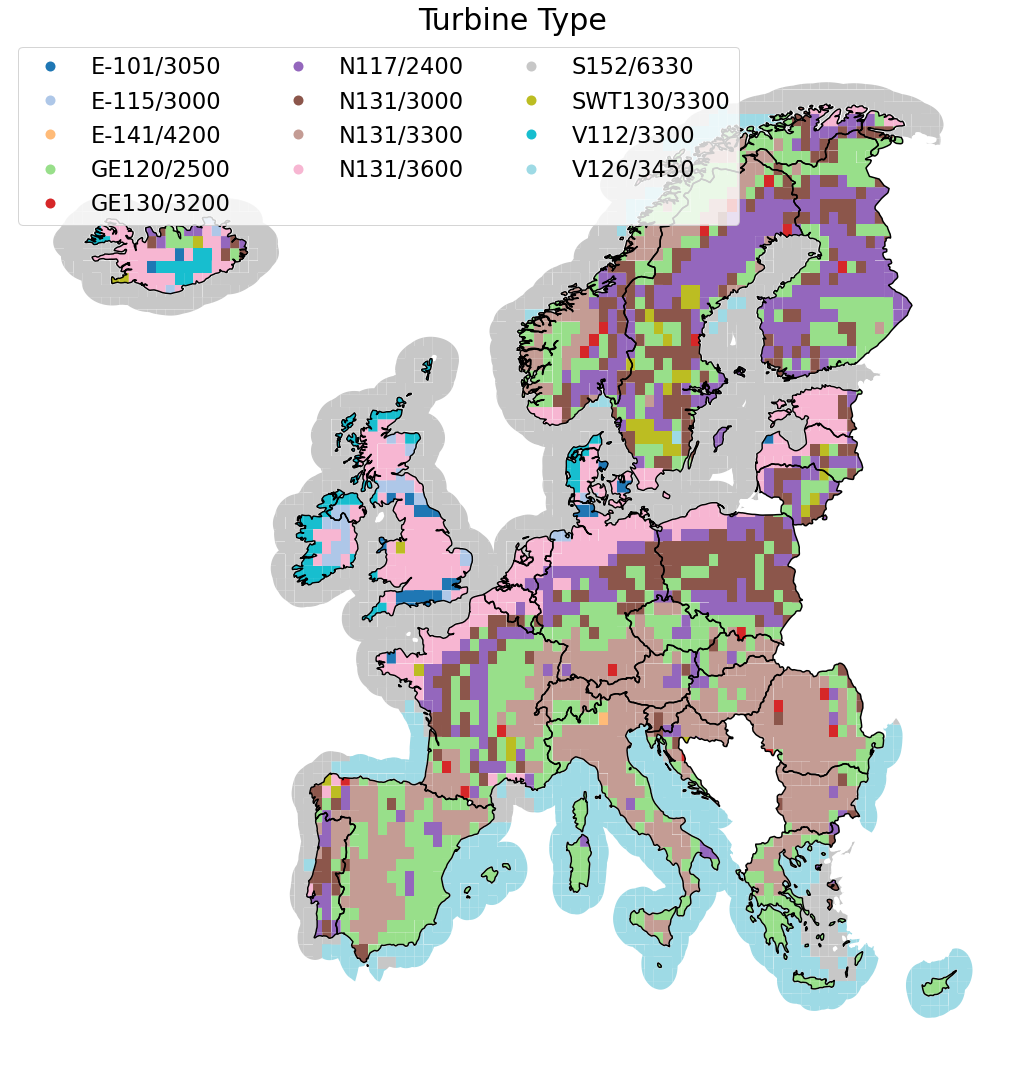

In [58]:
data = results_gdf.copy()
metrics = {'turbine_type':'Turbine Type'}
vmax_dict = None
legend_kwds = {'loc':'upper left'}
fontsize = 30
plot_results(data=data,countries=countries,metrics=metrics,legend_kwds=legend_kwds,figsize=(15,15),fontsize=fontsize)
plt.tight_layout()
# plt.savefig('../../gfx/turbine_types.png',dpi=400)

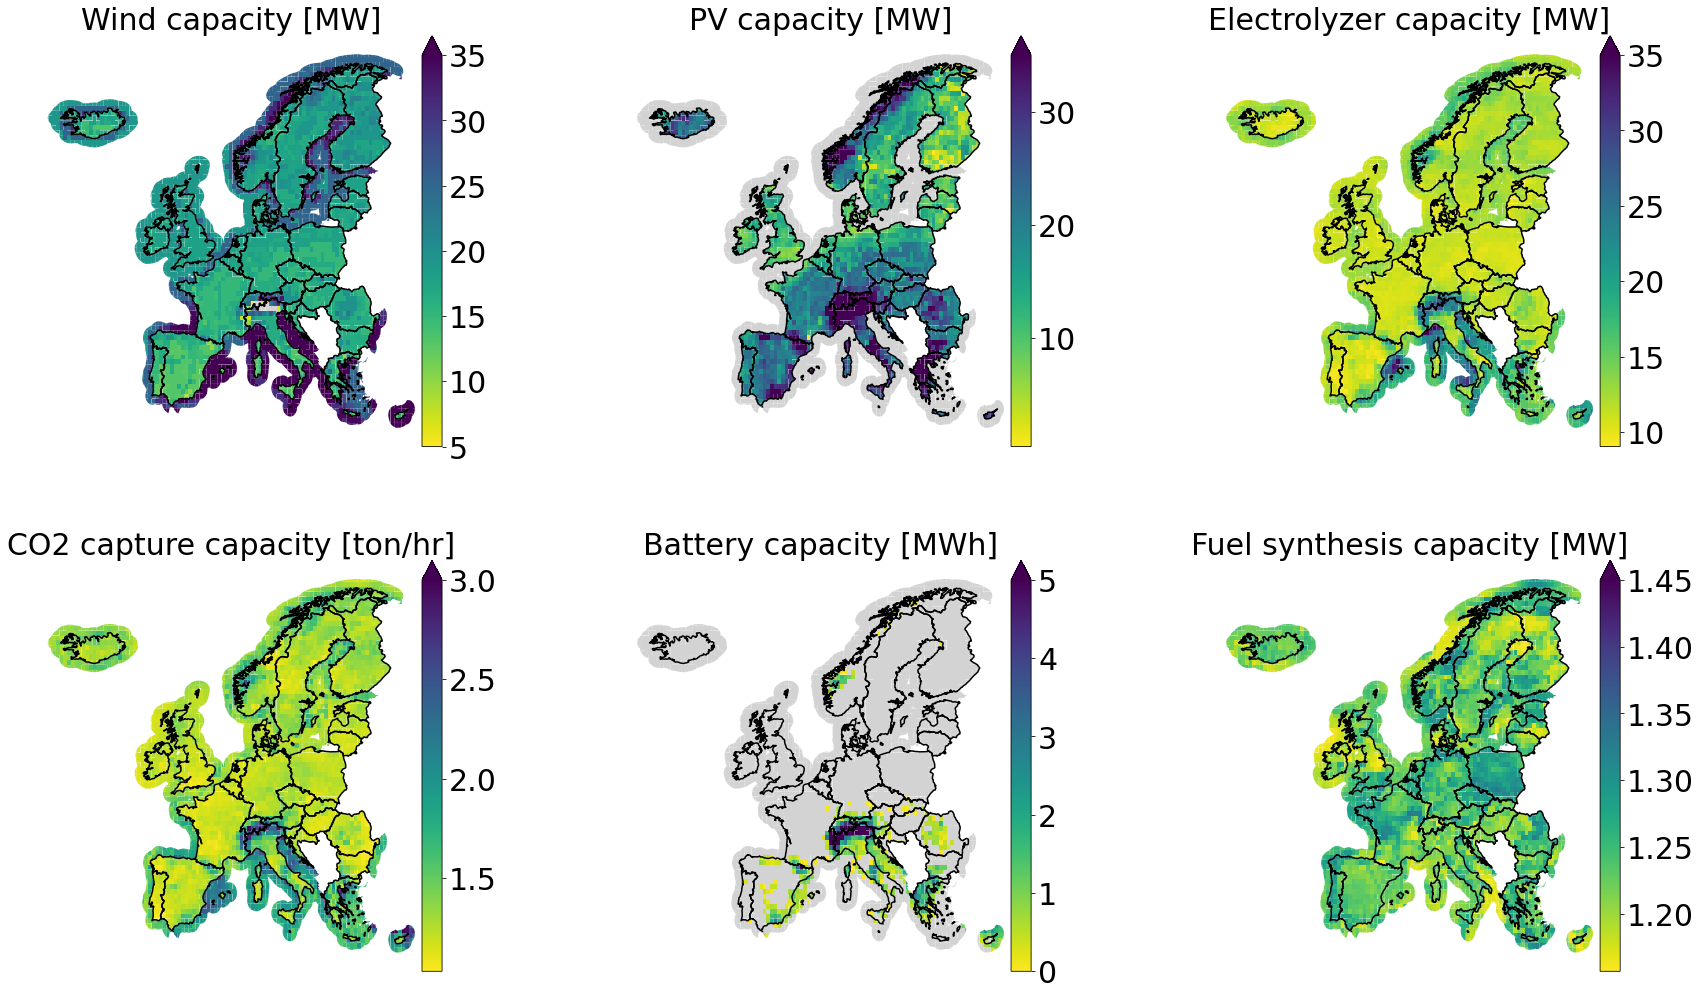

In [77]:
data = results_gdf.copy()
data.loc[data.battery_capacity_MWh==0,'battery_capacity_MWh'] = np.nan
data.loc[data.PV_capacity_MW==0,'PV_capacity_MW'] = np.nan
data.loc[data.wind_capacity_MW==0,'wind_capacity_MW'] = np.nan
metrics = {'wind_capacity_MW':'Wind capacity [MW]',
           'PV_capacity_MW':'PV capacity [MW]',
           'electrolyzer_capacity_MW':'Electrolyzer capacity [MW]',
           'CO2_capture_tonph':'CO2 capture capacity [ton/hr]',
           'battery_capacity_MWh':'Battery capacity [MWh]',
           'H2tL_capacity_MW':'Fuel synthesis capacity [MW]'}
vmax_dict = {'wind_capacity_MW':35,
             'PV_capacity_MW':35,
             'electrolyzer_capacity_MW':35,
             'CO2_capture_tonph':3,
             'battery_capacity_MWh':5,
             'H2tL_capacity_MW':1.45}
legend_kwds = {'extend':'max','orientation':'vertical'}
missing_kwds = {'color':'lightgrey'}
fontsize = 30
plot_results(data=data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,missing_kwds=missing_kwds,legend_kwds=legend_kwds,figsize=(25,15),fontsize=fontsize)
plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0.08)
plt.savefig('../../gfx/component_capacities.png',dpi=400)

# Costs

In [224]:
specs = pd.read_excel('../../data/plant_assumptions.xlsx',sheet_name='data',index_col=0)
specs_names = specs.index

In [225]:
year=2020
costs_df = results_gdf.copy()
components = {'wind':['wind_capacity_MW',1e3],
              'PV':['PV_capacity_MW',1e3],
              'battery':['battery_capacity_MWh',1e3],
              'electrolyzer':['electrolyzer_capacity_MW',1e3],
              'CO2':['CO2_capture_tonph',1e3],
              'H2stor':['H2stor_capacity_MWh',1e3],
              'CO2stor':['CO2stor_capacity_ton',1],
              'H2tL':['H2tL_capacity_MW',1e3],
              'heat':['heatpump_capacity_MW',1e3]}
discount_rate = specs.at['discount_rate',f'value_{year}']
plant_lifetime = specs.at['lifetime',f'value_{year}']

for component in components.keys():
    costs_df[component+'_NPV'] = np.nan
costs_df['verify_NPV'] = np.nan
    
for idx,row in data.iterrows():
    verify_NPV = 0
    for component,value in components.items():
        if component == 'wind':
            wind_class = row['wind_class']
            capex = specs.at[f'{component}_{wind_class}_CAPEX',f'value_{year}']
            opex = specs.at[f'{component}_{wind_class}_OPEX',f'value_{year}']
        else:
            capex = specs.at[f'{component}_CAPEX',f'value_{year}']
            opex = specs.at[f'{component}_OPEX',f'value_{year}']
        component_lifetime = specs.at[f'{component}_lifetime',f'value_{year}']
        capacity = row[value[0]]*value[1]
        if component == 'electrolyzer':
            component_npv = pop.costs_NPV(capex=capex,opex=opex,discount_rate=discount_rate,plant_lifetime=plant_lifetime,component_lifetime=component_lifetime,capacity=capacity,
                                          replacement_capex_fraction=specs.at['electrolyzer_stack_CAPEX',f'value_{year}'])                
        else:
            component_npv = pop.costs_NPV(capex=capex,opex=opex,discount_rate=discount_rate,plant_lifetime=plant_lifetime,component_lifetime=component_lifetime,capacity=capacity,)
        costs_df.loc[idx,component+'_NPV'] = component_npv
        verify_NPV += component_npv
    costs_df.loc[idx,'verify_NPV'] = verify_NPV

In [226]:
npv_cols = [x for x in costs_df.columns if 'NPV' in x]
costs_summary = costs_df[npv_cols].describe(percentiles=[0.05,0.5,0.95])
costs_summary

,NPV_EUR,wind_NPV,PV_NPV,battery_NPV,electrolyzer_NPV,CO2_NPV,H2stor_NPV,CO2stor_NPV,H2tL_NPV,heat_NPV,verify_NPV
count,5.390000e+03,5.390000e+03,5.390000e+03,5.390000e+03,5.390000e+03,5.390000e+03,5.390000e+03,5.390000e+03,5.390000e+03,5.390000e+03,5.390000e+03
mean,1.238355e+08,8.700725e+07,1.078449e+07,2.356873e+05,2.052771e+07,2.470804e+06,1.270354e+07,1.274589e+06,1.385458e+06,4.034495e+05,1.367930e+08
std,3.832939e+07,7.064476e+07,1.429059e+07,1.810291e+06,5.675752e+06,5.486909e+05,9.271847e+06,1.191971e+06,4.083821e+04,9.851495e+04,7.715192e+07
min,8.498614e+07,-0.000000e+00,0.000000e+00,0.000000e+00,1.373137e+07,1.797693e+06,1.911064e+06,1.797229e+05,1.297470e+06,2.824600e+05,6.164296e+07
5%,9.088900e+07,3.087759e+07,0.000000e+00,0.000000e+00,1.576698e+07,1.968862e+06,4.276201e+06,3.471299e+05,1.319047e+06,3.124899e+05,6.951463e+07
50%,1.116588e+08,4.891010e+07,8.642048e+06,0.000000e+00,1.865085e+07,2.280591e+06,1.016211e+07,7.873426e+05,1.382710e+06,3.695447e+05,1.060601e+08
95%,2.045864e+08,2.239018e+08,3.067309e+07,8.003500e+05,3.314399e+07,3.636869e+06,2.747164e+07,4.195413e+06,1.455299e+06,6.127255e+05,2.979666e+08
max,4.349160e+08,6.155363e+08,1.615490e+08,4.483344e+07,5.424430e+07,6.934645e+06,1.499551e+08,6.821415e+06,1.503378e+06,1.207305e+06,6.994013e+08


<BarContainer object of 11 artists>

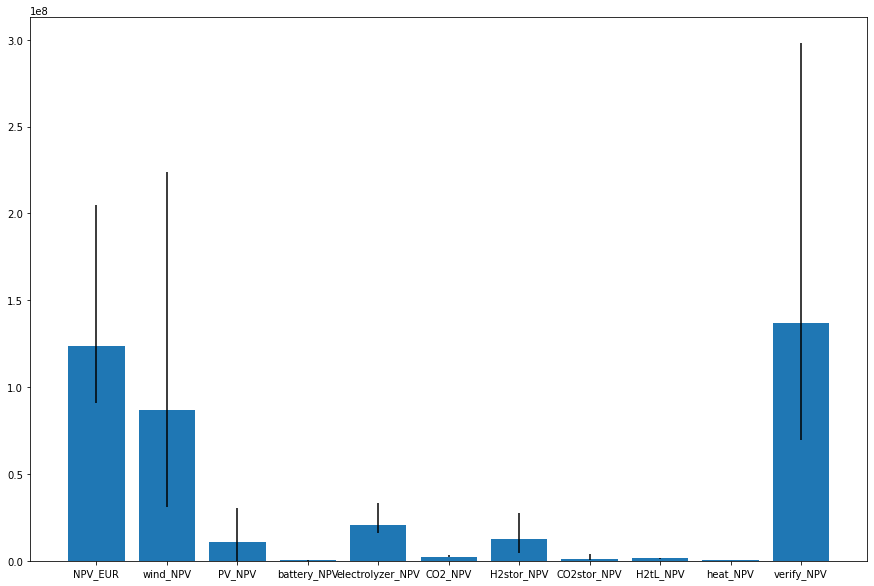

In [229]:
fig,axes = plt.subplots(figsize=(15,10))
# axes.bar(costs_summary.columns,costs_summary.loc['97.5%'],hatch='/',alpha=edgecolor='black')
axes.bar(costs_summary.columns,costs_summary.loc['mean'],yerr=[costs_summary.loc['mean']-costs_summary.loc['5%'],costs_summary.loc['95%']-costs_summary.loc['mean']])


<AxesSubplot:>

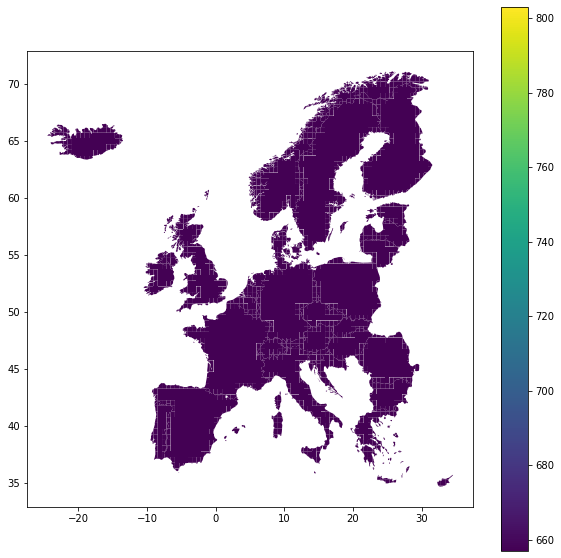

In [140]:
costs_df.plot(column='CO2_CAPEX',legend=True,figsize=(10,10))

In [126]:
costs_df = results_gdf.copy()
costs_df = pd.concat([costs_df,pd.DataFrame(npv_dict,index=costs_df.index)],axis=1)#,ignore_index=True)
costs_df

,CAPEX_EUR,CO2_CAPEX,CO2_OPEX,CO2_capture_tonph,CO2_el_efficiency,CO2_lifetime,CO2_max_capacity,CO2_min_capacity,CO2_th_efficiency,CO2stor_CAPEX,...,geometry,wind_NPV,PV_NPV,battery_NPV,electrolyzer_NPV,CO2_NPV,H2stor_NPV,CO2stor_NPV,H2tL_NPV,heat_NPV
0,5.768365e+07,730.0,0.04,1.278461,1.6,12.0,100000.0,0.0,0.4,1500.0,...,"POLYGON ((16.56250 48.75000, 16.70675 48.75000...",4.448424e+07,1.358794e+07,0.000000e+00,1.698091e+07,2.231534e+06,4.698971e+06,5.445132e+08,1.437168e+06,359299.364524
1,5.768958e+07,730.0,0.04,1.260226,1.6,12.0,100000.0,0.0,0.4,1500.0,...,"POLYGON ((16.70675 48.75000, 16.56250 48.75000...",3.971808e+07,1.833170e+07,0.000000e+00,1.583106e+07,2.199705e+06,5.154722e+06,6.163475e+08,1.390838e+06,354928.587541
2,1.810076e+08,730.0,0.04,2.721547,1.6,12.0,100000.0,0.0,0.4,1500.0,...,"POLYGON ((9.55984 47.25000, 9.68750 47.25000, ...",9.611774e+07,5.955735e+07,2.103878e+06,3.717713e+07,4.750419e+06,4.579698e+07,4.880060e+09,1.317275e+06,806104.757708
3,1.046885e+08,730.0,0.04,1.406044,1.6,12.0,100000.0,0.0,0.4,1500.0,...,"POLYGON ((9.68750 47.52951, 9.68750 47.25000, ...",6.116584e+07,4.012997e+07,1.021516e+06,2.772388e+07,2.454229e+06,1.320719e+07,1.042198e+09,1.355086e+06,401738.006842
4,1.600427e+08,730.0,0.04,2.208696,1.6,12.0,100000.0,0.0,0.4,1500.0,...,"POLYGON ((9.68750 47.25000, 10.31250 47.25000,...",8.737977e+07,6.325129e+07,2.095810e+06,3.657419e+07,3.855246e+06,2.651457e+07,3.767537e+09,1.318330e+06,654726.460634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5385,5.489553e+07,NaN,NaN,1.457264,NaN,NaN,NaN,NaN,NaN,NaN,...,"POLYGON ((-6.56250 49.75000, -5.93750 49.75000...",1.297075e+08,0.000000e+00,0.000000e+00,1.940651e+07,2.543632e+06,1.647936e+07,1.463824e+09,1.413225e+06,416116.406231
5386,5.412710e+07,NaN,NaN,1.345994,NaN,NaN,NaN,NaN,NaN,NaN,...,"POLYGON ((-6.56250 50.25000, -5.93750 50.25000...",8.256711e+07,0.000000e+00,0.000000e+00,1.947221e+07,2.349413e+06,1.595175e+07,1.011978e+09,1.397064e+06,381665.730711
5387,5.362224e+07,NaN,NaN,1.303502,NaN,NaN,NaN,NaN,NaN,NaN,...,"POLYGON ((-6.56250 50.75000, -5.93750 50.75000...",8.256711e+07,0.000000e+00,0.000000e+00,1.954090e+07,2.275243e+06,1.539343e+07,9.432111e+08,1.377590e+06,368897.710702
5388,5.377015e+07,NaN,NaN,1.248813,NaN,NaN,NaN,NaN,NaN,NaN,...,"POLYGON ((-6.46201 51.25000, -5.93750 51.25000...",1.297075e+08,0.000000e+00,0.000000e+00,1.927581e+07,2.179784e+06,1.589174e+07,8.513939e+08,1.358526e+06,352289.781680


In [82]:
list([x for x in results_gdf.columns if 'capacity' in x])

['CO2_max_capacity',
 'CO2_min_capacity',
 'CO2stor_capacity_ton',
 'CO2stor_max_capacity',
 'CO2stor_min_capacity',
 'H2stor_capacity_MWh',
 'H2stor_max_capacity',
 'H2stor_min_capacity',
 'H2tL_capacity_MW',
 'H2tL_max_capacity',
 'H2tL_min_capacity',
 'PV_capacity_MW',
 'PV_max_capacity',
 'PV_min_capacity',
 'battery_capacity_MWh',
 'battery_max_capacity',
 'battery_min_capacity',
 'electrolyzer_capacity_MW',
 'electrolyzer_max_capacity',
 'electrolyzer_min_capacity',
 'heat_max_capacity',
 'heat_min_capacity',
 'heatpump_capacity_MW',
 'wind_capacity_MW']

In [83]:
list(results_gdf.columns)

['CAPEX_EUR',
 'CO2_CAPEX',
 'CO2_OPEX',
 'CO2_capture_tonph',
 'CO2_el_efficiency',
 'CO2_lifetime',
 'CO2_max_capacity',
 'CO2_min_capacity',
 'CO2_th_efficiency',
 'CO2stor_CAPEX',
 'CO2stor_OPEX',
 'CO2stor_capacity_ton',
 'CO2stor_lifetime',
 'CO2stor_max_capacity',
 'CO2stor_min_capacity',
 'H2stor_CAPEX',
 'H2stor_OPEX',
 'H2stor_capacity_MWh',
 'H2stor_lifetime',
 'H2stor_max_capacity',
 'H2stor_min_capacity',
 'H2tL_CAPEX',
 'H2tL_OPEX',
 'H2tL_baseload',
 'H2tL_capacity_MW',
 'H2tL_chem_efficiency',
 'H2tL_el_efficiency',
 'H2tL_heat_output',
 'H2tL_lifetime',
 'H2tL_max_capacity',
 'H2tL_min_capacity',
 'H2tL_required_CO2',
 'LCOF_MWh',
 'LCOF_liter',
 'NPV_EUR',
 'PV_CAPEX',
 'PV_OPEX',
 'PV_capacity_MW',
 'PV_lifetime',
 'PV_max_capacity',
 'PV_min_capacity',
 'PV_peak_per_area',
 'PV_production_MWh',
 'battery_CAPEX',
 'battery_OPEX',
 'battery_c_rate',
 'battery_capacity_MWh',
 'battery_cycle_efficiency',
 'battery_lifetime',
 'battery_max_capacity',
 'battery_min_capaci

# Runtime limit

In [23]:
runtime_limit = 3000
print(len(results_gdf.loc[results_gdf.runtime>=runtime_limit]),'Points reached the runtime limit')

0 Points reached the runtime limit


10 outlier entries were dropped.


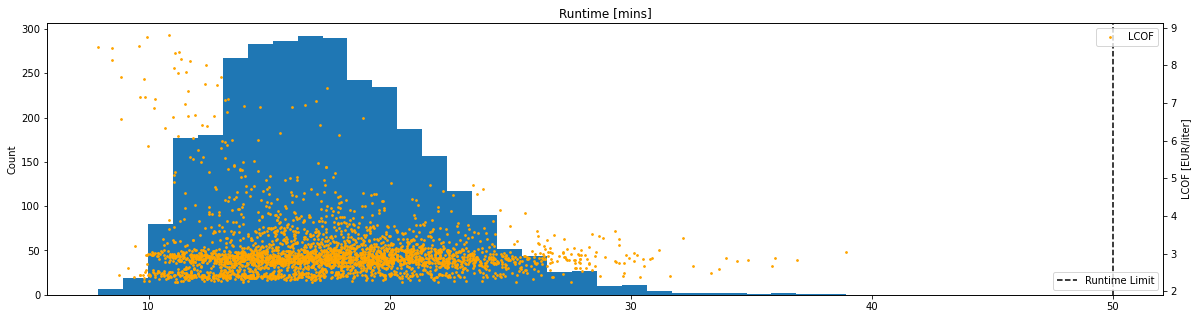

In [26]:
data = drop_outliers(results_gdf,z_score_filter=7)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,5))
ax.hist(data.runtime/60,bins=30)
ax.axvline(runtime_limit/60,c ='k',linestyle='--',label='Runtime Limit') # Runtime limit
ax2 = plt.twinx(ax)
ax2.scatter(data.runtime/60,data.LCOF_liter,color='orange',s=3,label='LCOF');
ax.set_title('Runtime [mins]')
ax2.set_ylabel('LCOF [EUR/liter]')
ax2.legend(loc='upper right')
ax.legend(loc='lower right')
ax.set_ylabel('Count');

# Distributions

10 outlier entries were dropped.


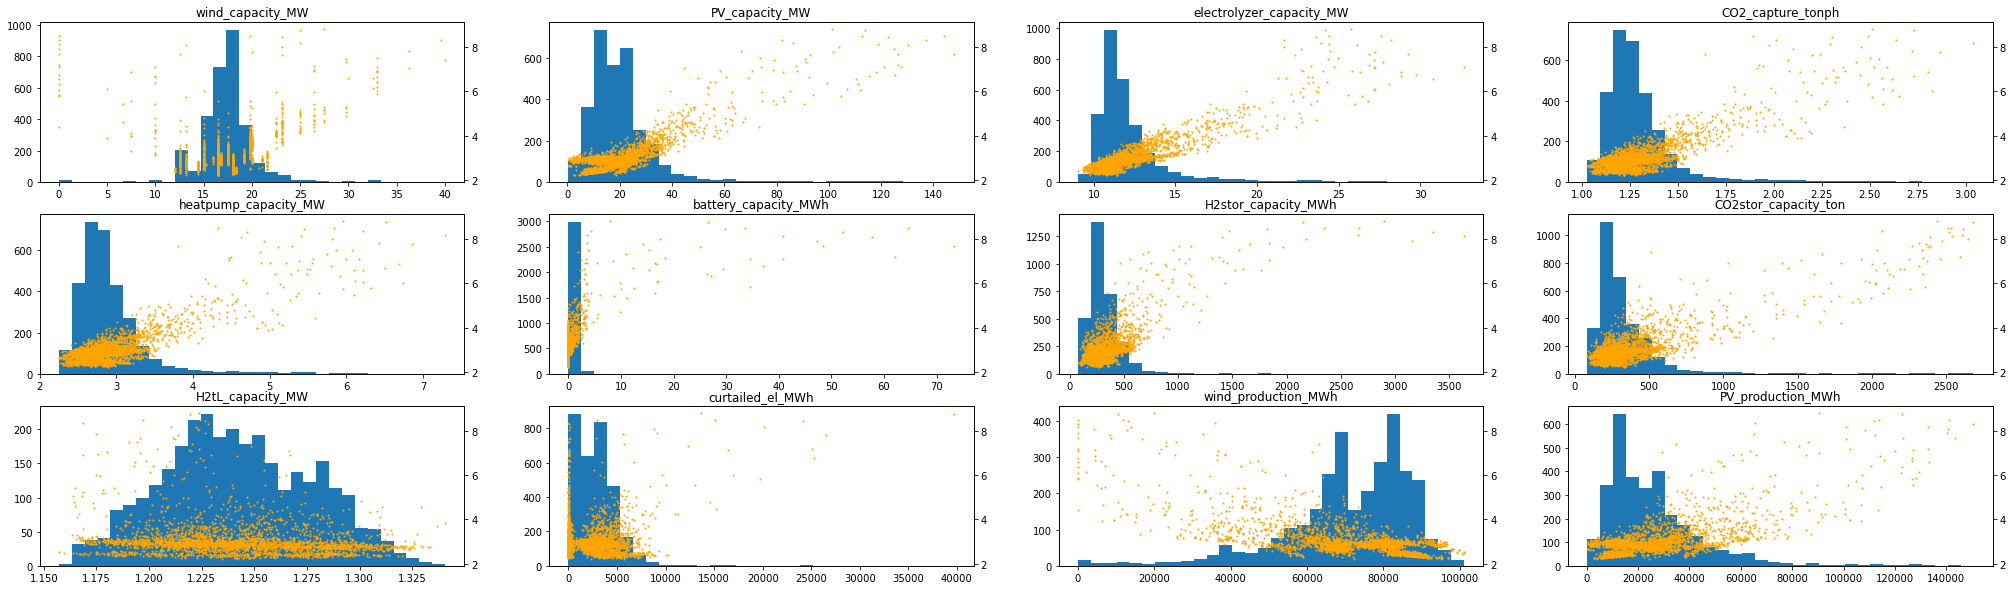

In [27]:
data = drop_outliers(results_gdf,z_score_filter=7)

metrics = ['wind_capacity_MW','PV_capacity_MW', 'electrolyzer_capacity_MW', 'CO2_capture_tonph',
       'heatpump_capacity_MW', 'battery_capacity_MWh', 'H2stor_capacity_MWh',
       'CO2stor_capacity_ton', 'H2tL_capacity_MW', 'curtailed_el_MWh',
       'wind_production_MWh', 'PV_production_MWh']
ncols=None
figsize=(35,10)
if ncols == None:
    ncols = int(np.ceil(np.sqrt(len(metrics))))
nrows = int(np.ceil(len(metrics)/ncols))
fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
axes = np.reshape(axes,(1,nrows*ncols))[0]
for i,metric in enumerate(metrics):
    axes[i].hist(data[metric],bins=30)
    ax2 = plt.twinx(axes[i])
    ax2.scatter(data[metric],data.LCOF_liter,s=1,color='orange')
    axes[i].set_title(metric)

# PV-Battery Relation

In [95]:
axes

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

10 outlier entries were dropped.


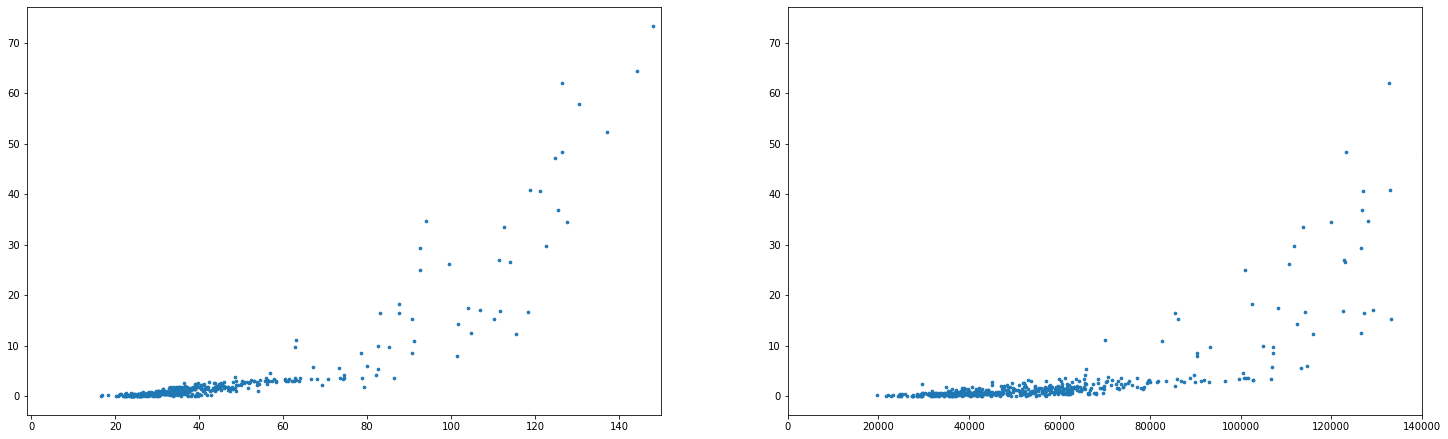

In [28]:
data = drop_outliers(results_gdf,z_score_filter=7)
data = data.loc[((data.PV_capacity_MW>0)&(data.PV_production_MWh>0)&(data.battery_capacity_MWh>0))]
fig,axes = plt.subplots(ncols=2,figsize=(25,7.5))
axes[0].scatter(data.PV_capacity_MW,data.battery_capacity_MWh,s=7)
axes[0].set_xlim(-1,150)
axes[1].scatter(data.PV_production_MWh,data.battery_capacity_MWh,s=7)
axes[1].set_xlim(-1,140000);


# 2050

In [25]:
results_path_2050 = os.path.join(results_path,'2050')
countries = europe_grid.country.unique()
# countries = ['France']
results_2050 = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path_2050}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['sea_node'] = False
    df_sea = pd.DataFrame()
    for file_glob in glob(f'{results_path_2050}/offshore/{country}*.csv'): 
        df_sea = df_sea.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df_sea['sea_node'] = True
    df = df.append(df_sea)
    df['country'] = country
    results_2050 = results_2050.append(df)
results_gdf_2050 = gpd.GeoDataFrame(results_2050.merge(europe_grid,on=['lat','lon','country','sea_node'],how='left'))

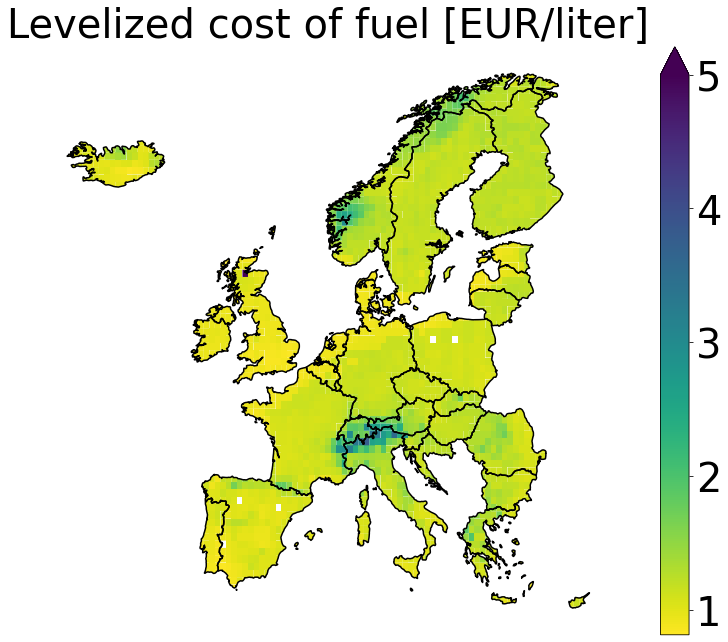

In [34]:
data = results_gdf_2050.copy()
# countries = ['Switzerland','Austria','Germany']
metrics = {'LCOF_liter':'Levelized cost of fuel [EUR/liter]'}
vmax_dict = {'LCOF_liter':5}
legend_kwds = {'extend':'max','orientation':'vertical'}
fontsize = 40
plot_results(data=data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,legend_kwds=legend_kwds,figsize=(15,15),fontsize=fontsize)

2 Points reached the runtime limit
1 outlier entries were dropped.


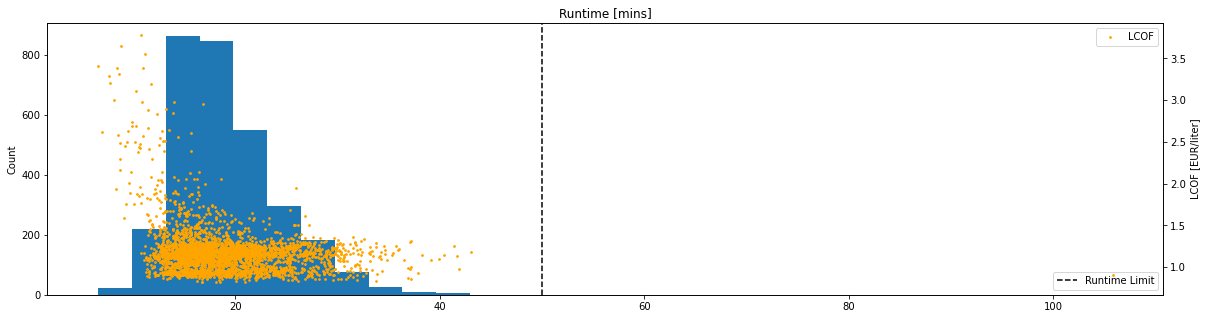

In [27]:
runtime_limit = 3000
print(len(results_gdf_2050.loc[results_gdf_2050.runtime>=runtime_limit]),'Points reached the runtime limit')

data = drop_outliers(results_gdf_2050,z_score_filter=7)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,5))
ax.hist(data.runtime/60,bins=30)
ax.axvline(runtime_limit/60,c ='k',linestyle='--',label='Runtime Limit') # Runtime limit
ax2 = plt.twinx(ax)
ax2.scatter(data.runtime/60,data.LCOF_liter,color='orange',s=3,label='LCOF');
ax.set_title('Runtime [mins]')
ax2.set_ylabel('LCOF [EUR/liter]')
ax2.legend(loc='upper right')
ax.legend(loc='lower right')
ax.set_ylabel('Count');

# 2030

In [11]:
results_path_2030 = os.path.join(results_path,'2030')
countries = europe_grid.country.unique()
# countries = ['France']
results_2030 = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path_2030}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['sea_node'] = False
    df_sea = pd.DataFrame()
    for file_glob in glob(f'{results_path_2030}/offshore/{country}*.csv'): 
        df_sea = df_sea.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df_sea['sea_node'] = True
    df = df.append(df_sea)
    df['country'] = country
    results_2030 = results_2030.append(df)
results_gdf_2030 = gpd.GeoDataFrame(results_2030.merge(europe_grid,on=['lat','lon','country','sea_node'],how='left'))

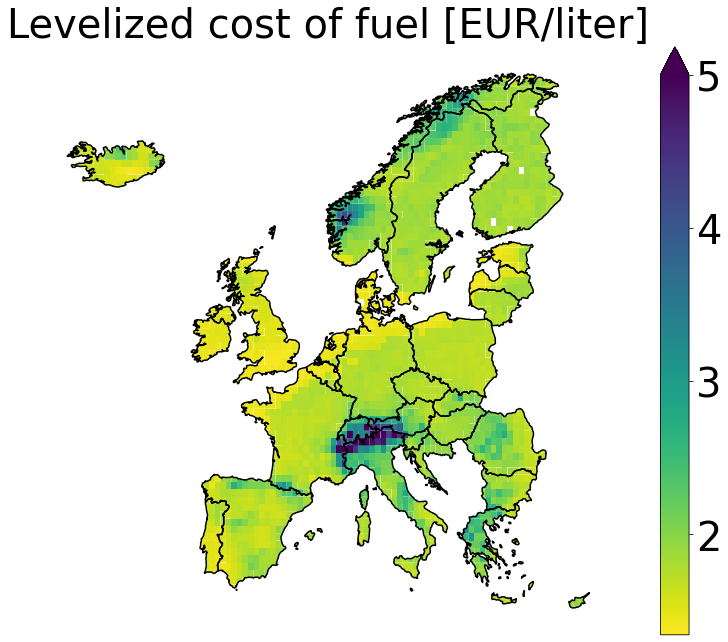

In [12]:
data = results_gdf_2030.copy()
# countries = ['Switzerland','Austria','Germany']
metrics = {'LCOF_liter':'Levelized cost of fuel [EUR/liter]'}
vmax_dict = {'LCOF_liter':5}
legend_kwds = {'extend':'max','orientation':'vertical'}
fontsize = 40
plot_results(data=data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,legend_kwds=legend_kwds,figsize=(15,15),fontsize=fontsize)

0 Points reached the runtime limit
10 outlier entries were dropped.


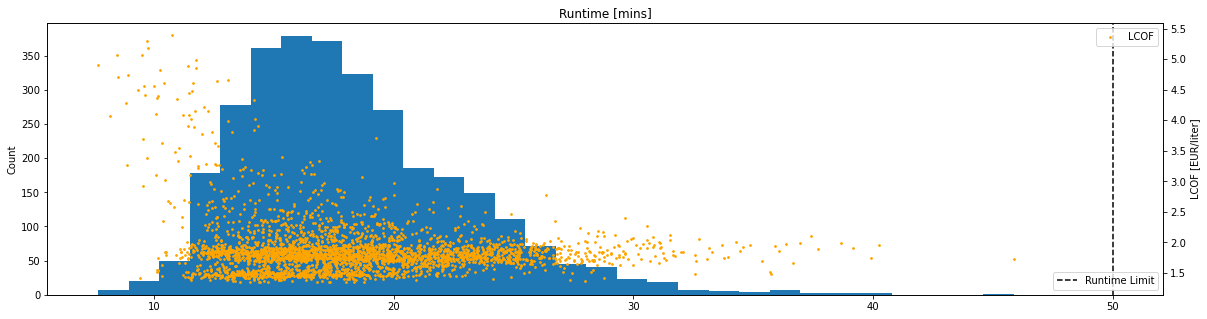

In [13]:
runtime_limit = 3000
print(len(results_gdf_2030.loc[results_gdf_2030.runtime>=runtime_limit]),'Points reached the runtime limit')

data = drop_outliers(results_gdf_2030,z_score_filter=7)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,5))
ax.hist(data.runtime/60,bins=30)
ax.axvline(runtime_limit/60,c ='k',linestyle='--',label='Runtime Limit') # Runtime limit
ax2 = plt.twinx(ax)
ax2.scatter(data.runtime/60,data.LCOF_liter,color='orange',s=3,label='LCOF');
ax.set_title('Runtime [mins]')
ax2.set_ylabel('LCOF [EUR/liter]')
ax2.legend(loc='upper right')
ax.legend(loc='lower right')
ax.set_ylabel('Count');

# Curtailed Electricity

1 outlier entries were dropped.


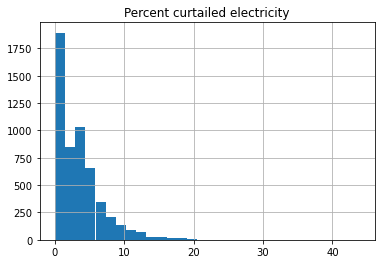

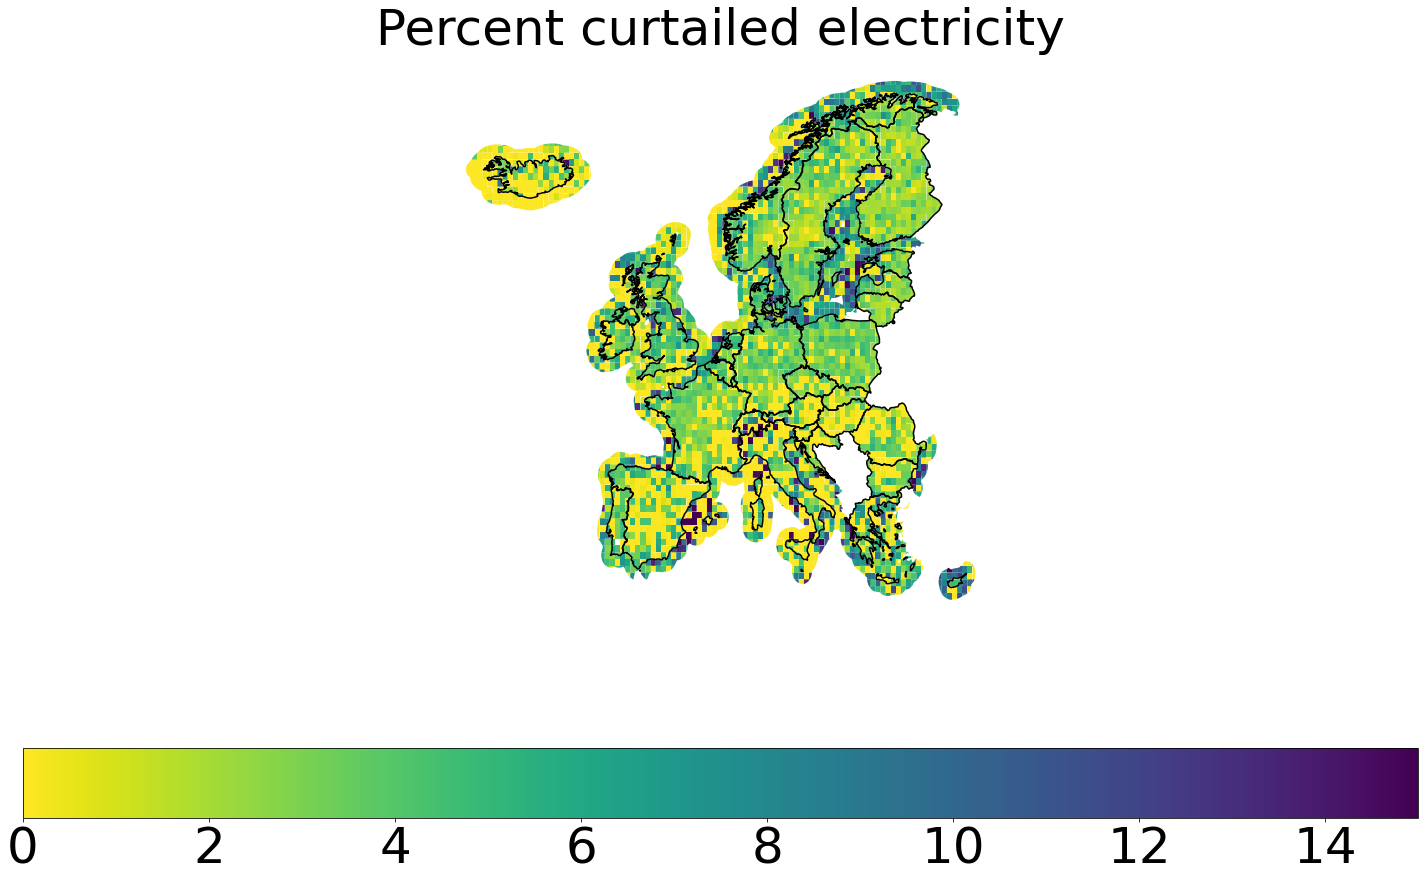

In [86]:
data = drop_outliers(results_gdf,z_score_filter==7)
data['percent_curtailed'] = data.curtailed_el_MWh/(data.PV_production_MWh+data.wind_production_MWh)*100
data.percent_curtailed.hist(bins=30)
plt.title('Percent curtailed electricity')

plot_results(data=data,countries=EU_EFTA,metrics={'percent_curtailed':'Percent curtailed electricity'},figsize=(25,15),ncols=None,fontsize=None,cmap=None,vmax_dict={'percent_curtailed':15},missing_kwds=None,legend_kwds={})

## Investigate high curtailed electricity

In [51]:
results_gdf.sort_values('curtailed_el_MWh',ascending=False).head(3)

,lat,lon,turbine_type,rotor_diameter,rated_turbine_power,wind_turbines,wind_capacity_MW,PV_capacity_MW,electrolyzer_capacity_MW,CO2_capture_tonph,...,PV_production_MWh,NPV_EUR,CAPEX_EUR,LCOF_MWh,LCOF_liter,runtime,country,PV_lat,PV_lon,geometry
50,47.5,10.625,N131/3300,131.0,3300.0,10.0,33.0,32.862530,14.276032,2.053427,...,26089.293703,1.317408e+08,8.061807e+07,804.649227,7.688870,1110.636494,Austria,47.390128,10.659047,"POLYGON ((10.93750 47.46889, 10.93750 47.25000..."
7,46.5,6.250,N131/3300,131.0,3300.0,7.0,23.1,23.527501,11.974207,1.221147,...,30478.994253,9.712394e+07,6.211337e+07,593.215669,5.668505,1008.013400,Switzerland,46.528093,6.329267,"POLYGON ((6.42015 46.75000, 6.56250 46.75000, ..."
6,46.0,10.000,GE120/2500,120.0,2500.0,9.0,22.5,148.706301,23.033372,2.207753,...,145623.739466,3.681098e+08,2.703777e+08,2248.348945,21.484223,432.779653,Switzerland,46.239057,10.098074,"POLYGON ((10.04078 46.25000, 10.15876 46.25000..."


In [62]:
country = 'Austria'
point = (47.5,10.625)
site = pop.Site(point,country)
plant = pop.Plant(site)
plant.operation = pd.read_parquet(f'../../results/02_plant_optimization/operation/{country}_{point[0]}_{point[1]}.parquet.gzip')
plant.operation.head()

,wind_production_kWh,PV_production_kWh,battery_chr_kWh,battery_dis_kWh,battery_state_kWh,H2stor_chr_kWh,H2stor_dis_kWh,H2stor_state_kWh,CO2stor_chr_kg,CO2stor_dis_kg,...,H2_el_kWh,CO2_el_kWh,H2tL_el_kWh,heat_el_kWh,battery_flow_kWh,H2_production_kWh,CO2_consumption_kg,CO2_production_kg,CO2stor_flow_kg,fuel_production_kWh
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:30:00,0.000000,0.0,0.0,254.831973,550.988050,9.995834e+06,1.000000e+07,69216.976394,9.999378e+06,1.000000e+07,...,0.000000,254.831973,0.0,0.0,-254.831973,0.000000,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 01:30:00,0.000000,0.0,0.0,254.831973,275.494025,0.000000e+00,4.165566e+03,65051.410616,9.999378e+06,1.000000e+07,...,0.000000,254.831973,0.0,0.0,-254.831973,0.000000,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 02:30:00,459.361453,0.0,0.0,0.000000,0.000000,0.000000e+00,4.042848e+03,60885.844838,9.999378e+06,1.000000e+07,...,204.529480,254.831973,0.0,0.0,0.000000,122.717688,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 03:30:00,2076.424904,0.0,0.0,0.000000,0.000000,0.000000e+00,3.072610e+03,56842.996747,0.000000e+00,6.217736e+02,...,1821.592931,254.831973,0.0,0.0,0.000000,1092.955759,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 04:30:00,4427.816467,0.0,0.0,0.000000,0.000000,9.998338e+06,1.000000e+07,53770.386728,0.000000e+00,6.217736e+02,...,4172.984494,254.831973,0.0,0.0,0.000000,2503.790697,159891.75673,159269.983129,-621.7736,1221.395576


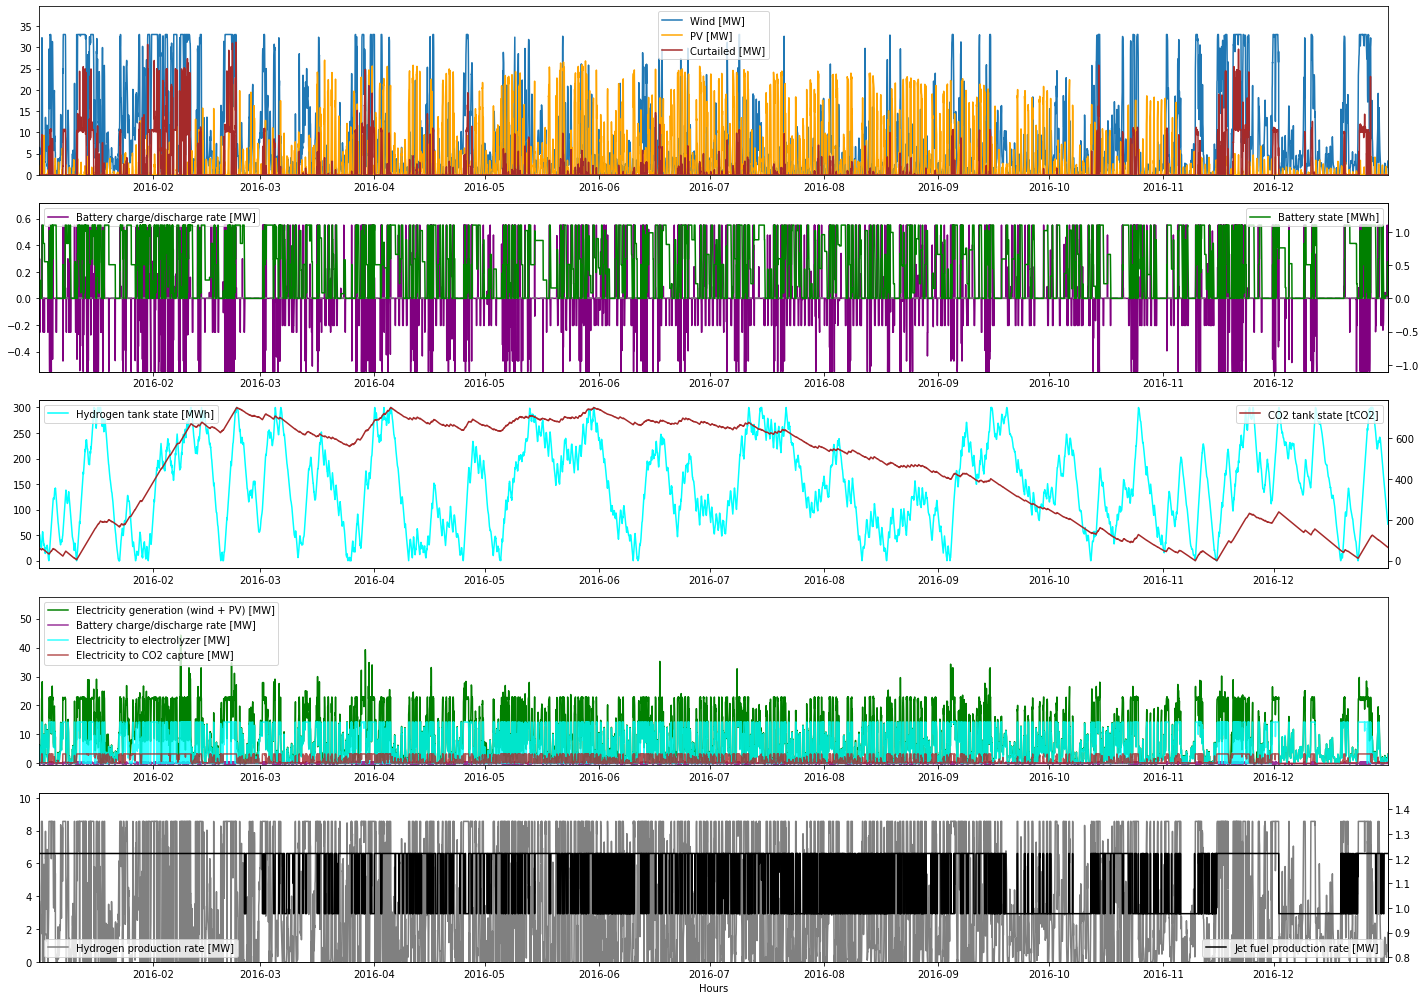

In [63]:
plot_plant_operation(plant)

AttributeError: 'DataFrame' object has no attribute 'site'

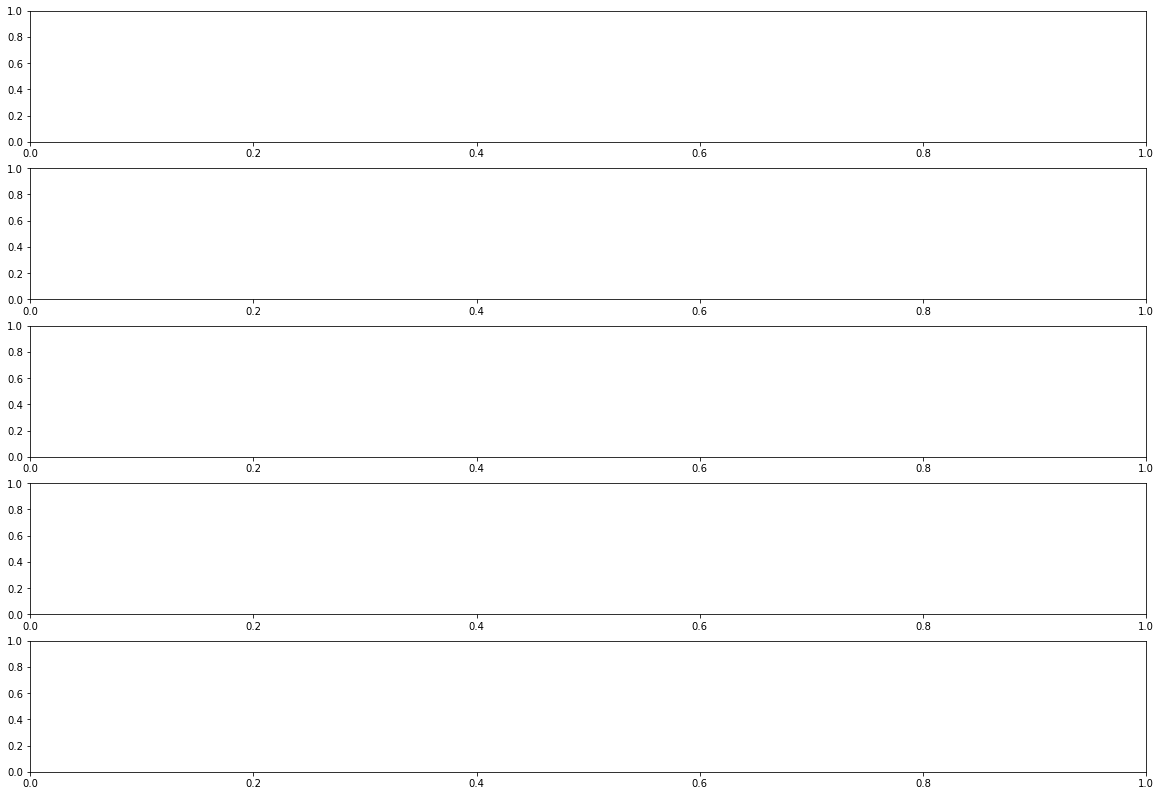